<a href="https://colab.research.google.com/github/M-ballabio1/API-Ultrasound-Classificator/blob/main/notebook/Biomedical_Image_Classification_RIGHT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

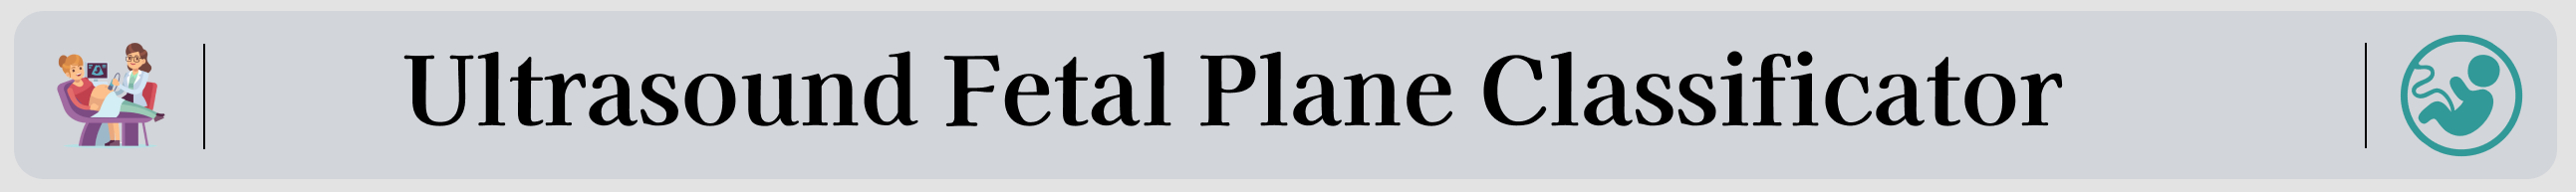

**Paper:** *MLOps: A Use Case in Biomedical Image Classification*

**Authors:** *Matteo Testi, Maria Chiara Fiorentino, Matteo Ballabio, Massimo
Ciccozzi, Emanuele Frontoni, Sara Moccia, Gennaro Vessio, Giorgio
Visani*

**Manteiner script:** *Matteo Ballabio*

**Task Goal:** The purpose of this notebook is to show the MLOps pipeline explained in the article. Starting from data acquisition, ML Design, Continuos Integration and Delivery. Moreover, two new passage of ML workflow are Explainable AI and Sustainable AI.

# **0. Software and Libraries Dependencies & Starting Project**

The main software dependencies are:

- Basic python package (numpy, cv2, pandas ecc...)

- Neptune software integration with CLI

- Carboon Footprint libraries (Carboncode, carbon tracker)

- Tensorflow and Scikit-Learn

## **Software Dependecies**

**Dependecies of Neptune.ai and Dependencies used to link Google Colab Notebook and Neptune.ai**

In [ ]:
!pip install --upgrade --quiet neptune-client

!pip install neptune-tensorflow-keras

!pip install neptune-notebooks

!jupyter nbextension enable --py neptune-notebooks

!pip show neptune-client

!pip show neptune-tensorflow-keras

!pip install neptune-client neptune-contrib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling notebook extension neptune-notebooks/neptune-notebook...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Name: neptune-client
Version: 1.1.1
Summary: Neptune Client
Home-page: https://neptune.ai/
Author: neptune.ai
Author-email: contact@neptune.ai
License: Apache-2.0
Location: /usr/local/lib/python3.9/dist-packages
Requires: boto3, bravado, click, future, GitPython, oauthlib, packaging, pandas, Pillow, psutil, PyJWT, requests, requests-oauthlib, six, swagger-spec-validator, urllib3, websocket-client
Required-by: neptune-contrib, neptune-notebooks
Name: neptune-tensorflow-keras
Version: 2.1.

**Dependencies CodeCarbon and CarbonTracker**

In [ ]:
pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install carbontracker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Add of Keras Library**

In [ ]:
!pip install keras.utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Visualization**

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Initialization of project with Neptune.ai**
With this command, you can starting a new Neptune.ai experiment and starting the monitoring of your experiment.
- Setting of API token from your Neptune.ai account
- "neptune.init_run" allows to link and store data on a particular Neptune.ai project (called in this way Biomedical-Imaging)

In [ ]:
import neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

In [ ]:
from getpass import getpass
api_token = getpass("Enter your private Netune API Token: ") # insert api token from account  eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZmUwOWE5Ni03NmVkLTQ4YzEtYTM5Zi1iZjczZjk0YzkwNmYifQ==

Enter your private Netune API Token: ··········


In [ ]:
run = neptune.init_run(project="dli-mlops/Biomedical-Imaging",
                   api_token=api_token,
                   name="Biomedical Imaging Experiment",)

https://app.neptune.ai/dli-mlops/Biomedical-Imaging/e/BIOM-43


# **1. Business Understanding**

**Abstract:**
*Integrating Machine Learning (ML) into the healthcare sector can revolutionize medical diagnosis and treatment. However, deploying and maintaining
ML models in clinical practice can be challenging, requiring robust processes
and technologies. This paper explores the application of Machine Learning
Operations (MLOps) to a specific biomedical use case, demonstrating the
potential benefits of using MLOps principles in a healthcare setting. The use
case is the supervised classification of fetal standard planes from gynecologic
ultrasound images, a fundamental step to assess and monitor fetal growth.
The MLOps pipeline is described in detail, including data preparation, model
training, deployment, and monitoring. The results of this study provide a
practical guide for researchers and practitioners interested in incorporating
MLOps into their projects to improve the reliability and efficiency of ML
models in the healthcare sector.*

##### **This part is a non-technical section without any coding passage**

# **2. Data Acquisition and Exploration**

There are few critical considerations regarding data acquisition in MLOps.
The first concerns **data quality** and **volume**. Data quality refers to the com-
pleteness of the data used to train and test ML models. This is a crucial step when dealing with US images. While high-quality data are essential to
building accurate and reliable ML models, images that are too clean may not
represent the complexity of the actual fetal US scan plane detection scenario,
which is characterized by various US artifacts.
The pipeline can be summarized in this phase:

- Storage data in GDrive repository

- Connection data with Data Ingestion source

- Pre-processing image with basic computer-vision algorithms to insure *Data Quality*

- Data Augmentation step allows to articially augment the *Data Volume* of our dataset


**Import libraries base ML project**

In [ ]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
# tensorflow libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalMaxPooling2D,BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout, Conv2D
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.callbacks import ModelCheckpoint,  CSVLogger
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
import visualkeras
# scikit libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
#from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from codecarbon import EmissionsTracker
# Import utils to upload the images on Neptune.ai Platform
from neptune.new.types import File

**Gpu Check**

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Data Acquisition and Storage**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
parent_folder = "/content/gdrive/MyDrive/MLOPS1:Biomedical Image Classification"
dir_path = os.path.join(parent_folder, "Train_dataset_unzipped/train")
dir_path_test = os.path.join(parent_folder,"test_planes")

**Tracking Files in Neptune's Artifacts**

In [ ]:
run["train/images"].track_files(dir_path)
run["test/images"].track_files(dir_path_test)
run["data/carbon_old"].track_files(file_path_carb_old)

**Initialize hyperparameters for Neptune.ai Data Augmentation**

In [ ]:
params = {'batch_size': 32,
          'learningRate':0.001,
          'momentum':0.98,
          "num_classes": 3,
          'epoche':100}
run["parameters"] = params

**Data Augmentation**

In [ ]:
data_gen_args = dict(samplewise_center=True,
                     samplewise_std_normalization=True,
                     rotation_range=40,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.3,
                     brightness_range=(0.3, 1.3))
train_datagen= ImageDataGenerator(**data_gen_args,fill_mode="constant", validation_split=0.2)
valid_datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True,validation_split=0.2)

In [ ]:
train_image_generator = train_datagen.flow_from_directory(dir_path, target_size=(224, 224), color_mode='rgb',batch_size = params['batch_size'],shuffle = True, seed=42,subset='training')
valid_image_generator = valid_datagen.flow_from_directory(dir_path, target_size=(224, 224),color_mode='rgb',batch_size = params['batch_size'],shuffle = True, seed=42,subset='validation')

Found 2928 images belonging to 3 classes.
Found 731 images belonging to 3 classes.


**Visualization of Data Augmentation**

/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
<ipython-input-55-8621e1e9bbb7>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1) = plt.subplots(1, 1)


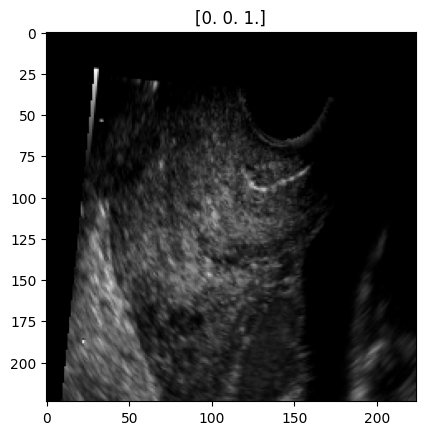

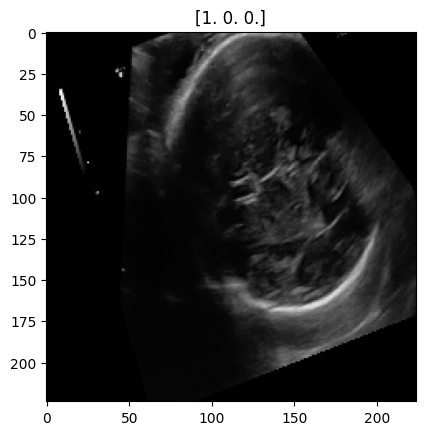

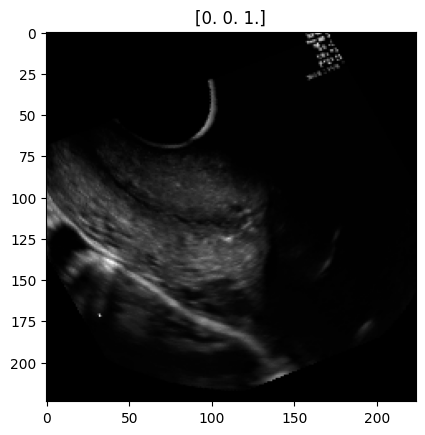

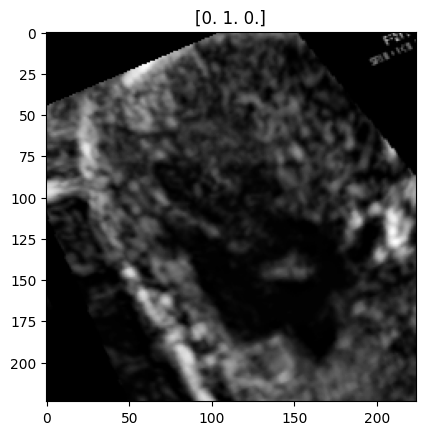

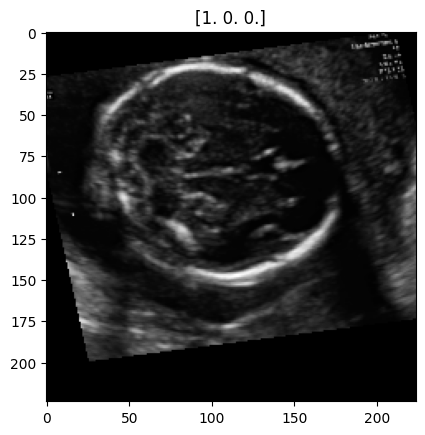

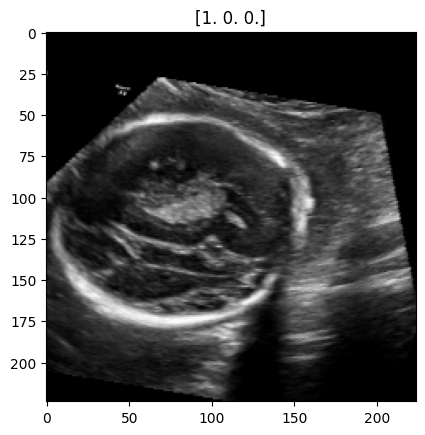

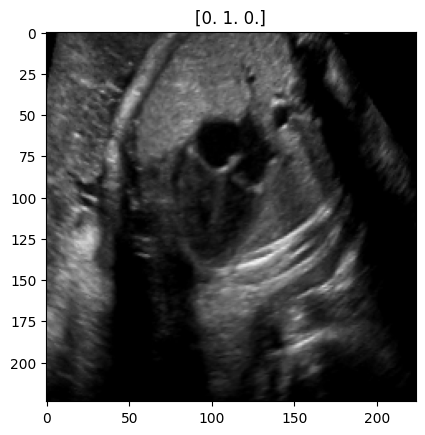

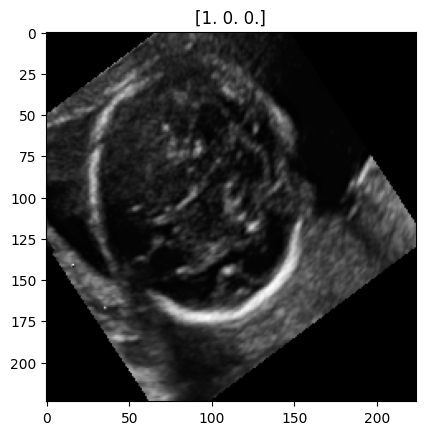

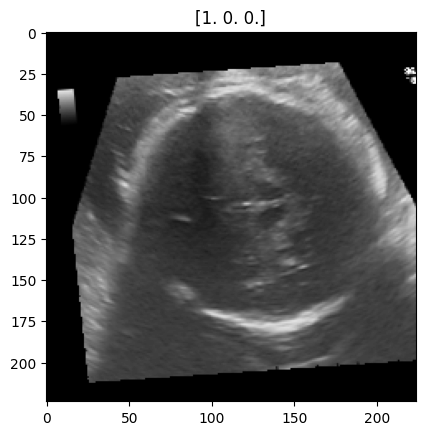

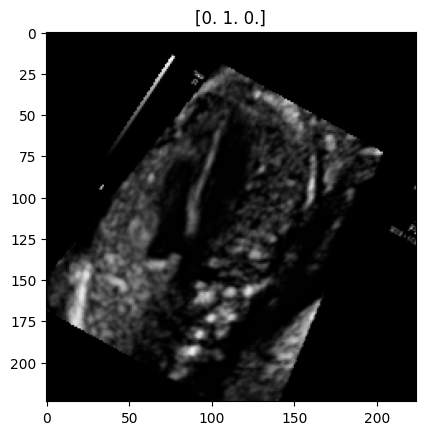

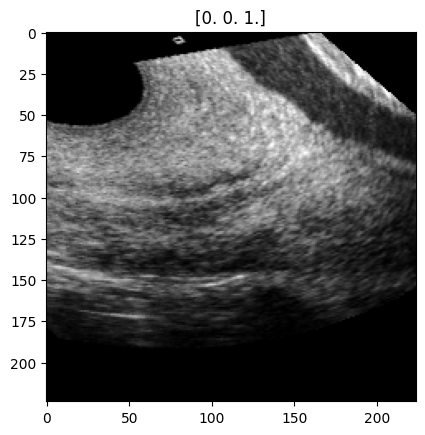

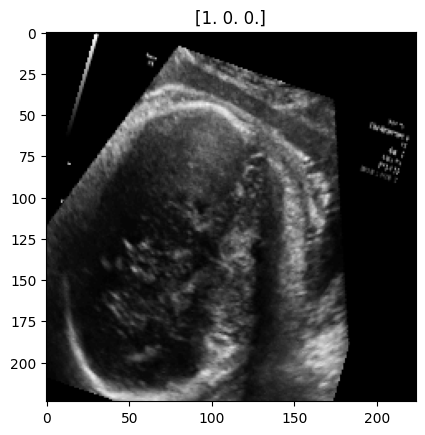

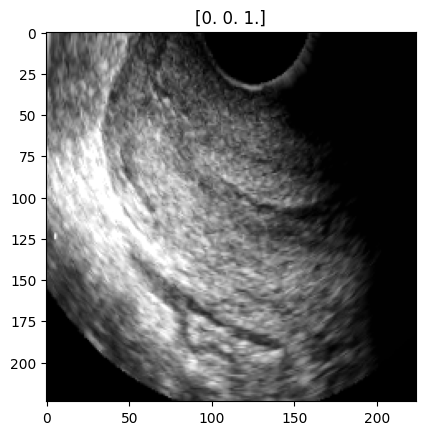

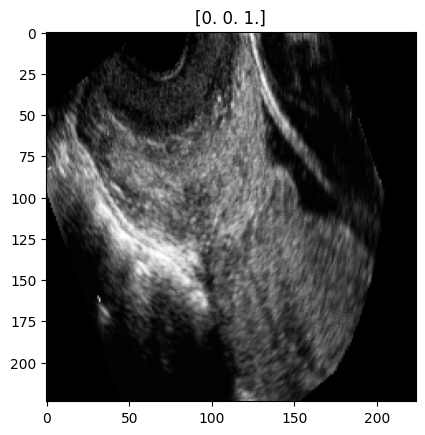

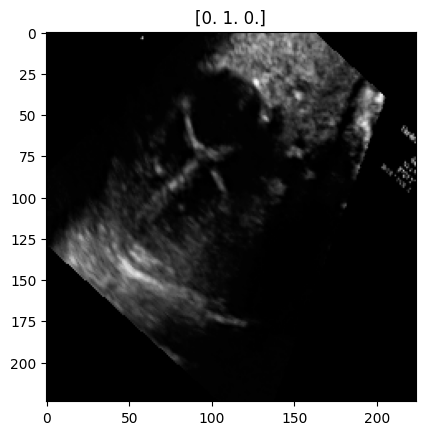

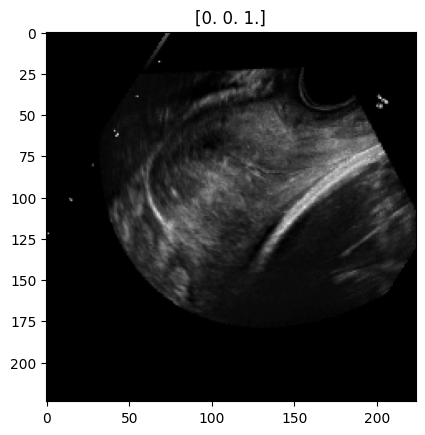

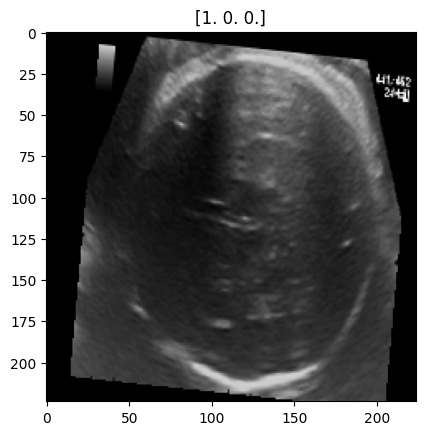

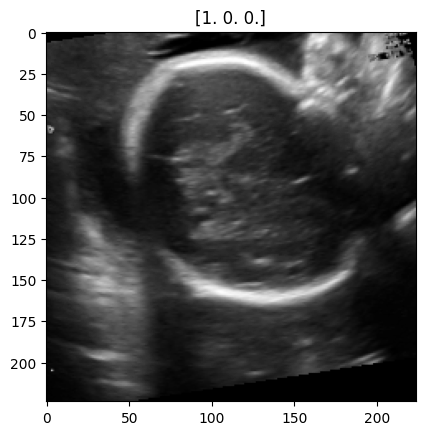

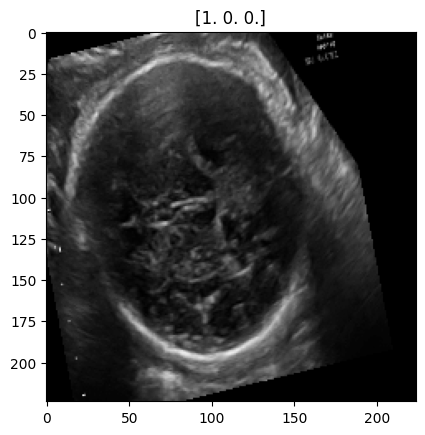

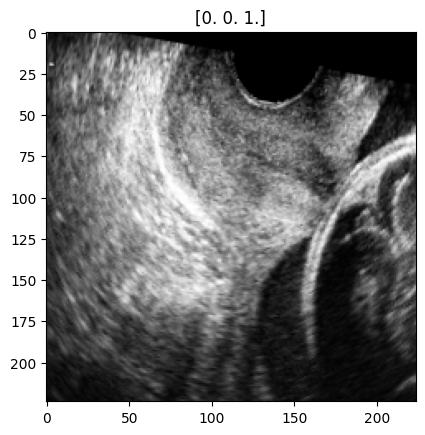

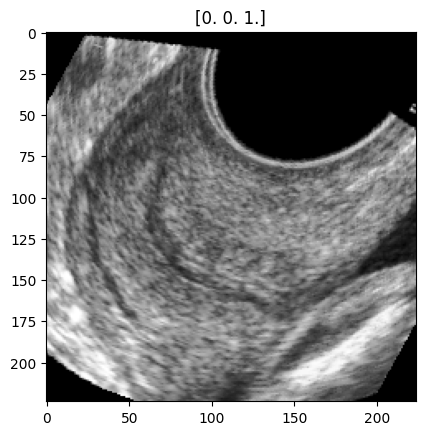

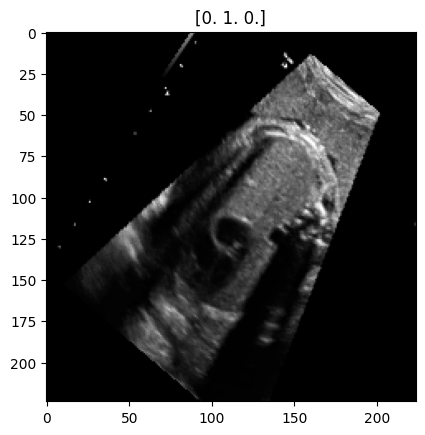

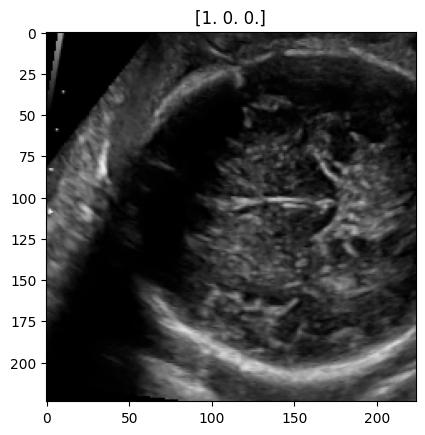

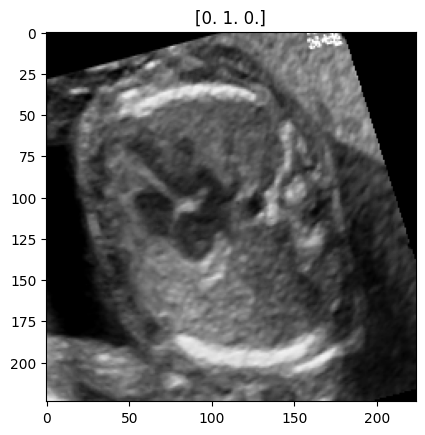

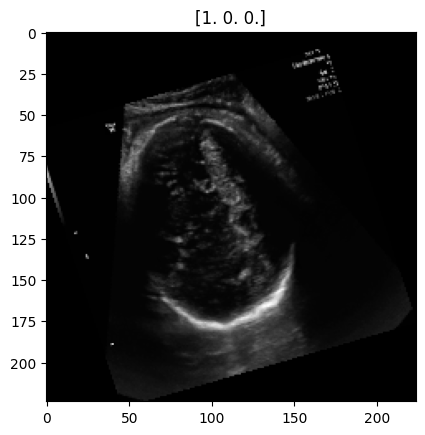

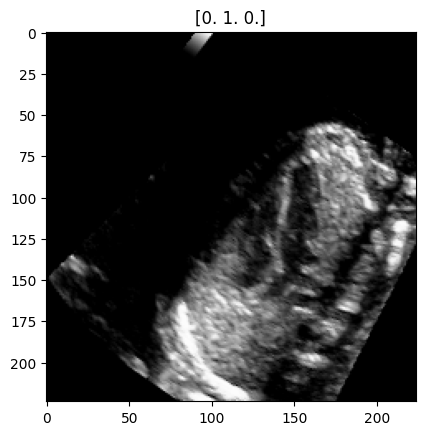

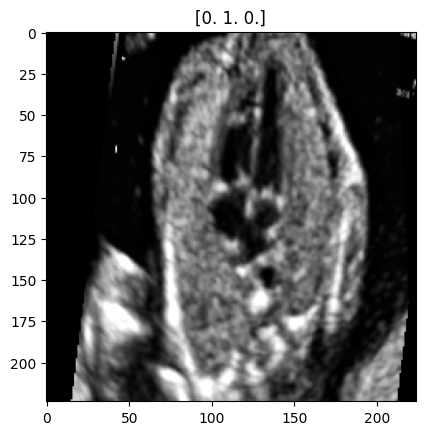

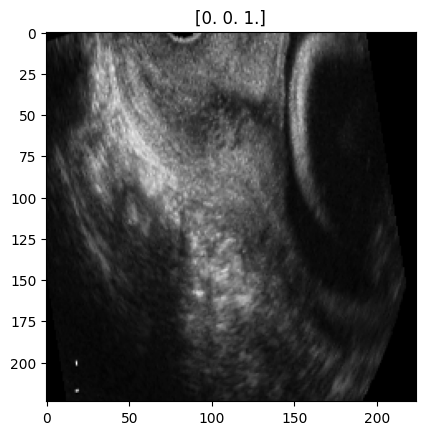

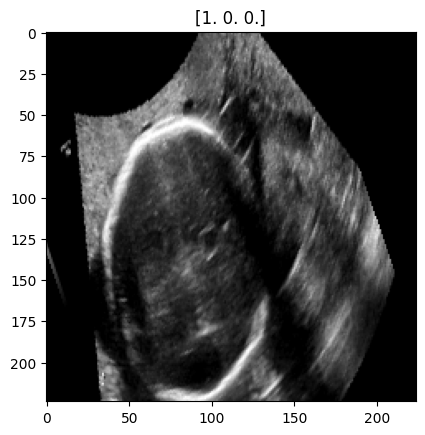

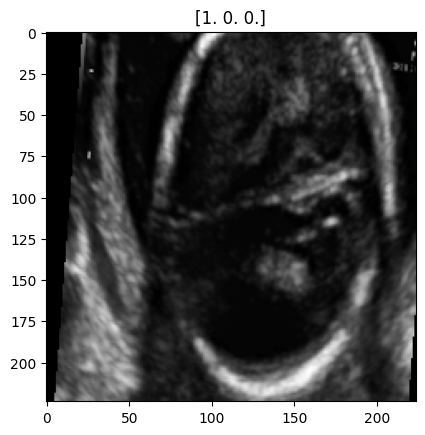

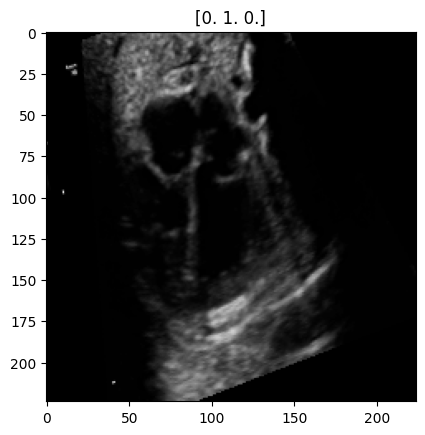

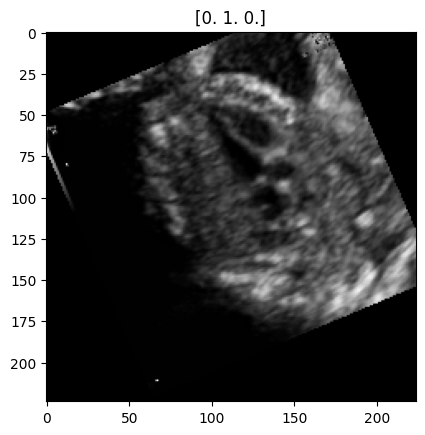

In [ ]:
batchx, batchy = next(train_image_generator)
for i in range(batchx.shape[0]):
    fig, (ax1) = plt.subplots(1, 1)
    ax1.set_title(batchy[i])
    ax1.imshow(batchx[i][:,:,0],cmap='gray')
    run["Data_Augmentation/data_augmentation-fig-example"].upload(fig)

#run["train/augmentation_images"].upload(batchx) --> Add images to metadata

# **3. ML Methodology**

In this way, we can choose our ML model according to tracking model on Neptune.ai.
For this task of clinical ultrasound classification, we decide to test three different architecture:

- ***Mobile-Net*** - Total params: 8,160,347 | Trainable params: 5,901,327 | Non-trainable params: 2,259,020
- ***Res-Net 50*** - Total params: 33,029,019 | Trainable params: 9,440,271 | Non-trainable params: 23,588,748
- ***Vgg-19*** - Total params: 22,387,803 | Trainable params: 2,362,383 | Non-trainable params: 20,025,420

The following step will be:

**3.1)** Tracking model Neptune.ai

**3.2)** Choose ML Architecture

**3.3)** Hyperparameters config


### **3.1) Tracking Model Versioning**
*In this part, you can track your different architecture tested in Neptune.ai platform. In this way, you can compare different architecture with different hyperparameters and find best solution.*

In [ ]:
## Mobile-net
model_version = neptune.init_model_version(
    model="BIOM-MB",
    project="dli-mlops/Biomedical-Imaging",
    api_token=api_token
)

https://app.neptune.ai/dli-mlops/Biomedical-Imaging/m/BIOM-MB/v/BIOM-MB-9


In [ ]:
## Res-Net50
model_version = neptune.init_model_version(
    model="BIOM-RSN",
    project="dli-mlops/Biomedical-Imaging",
    api_token=api_token
)

https://app.neptune.ai/dli-mlops/Biomedical-Imaging/m/BIOM-RSN/v/BIOM-RSN-3


In [ ]:
## VGG-19
model_version = neptune.init_model_version(
    model="BIOM-VGG",
    project="dli-mlops/Biomedical-Imaging",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5ZmUwOWE5Ni03NmVkLTQ4YzEtYTM5Zi1iZjczZjk0YzkwNmYifQ==", # your credentials
)

https://app.neptune.ai/dli-mlops/Biomedical-Imaging/m/BIOM-VGG/v/BIOM-VGG-3


### **3.2) Choice of the best ML Architecture**

In [ ]:
#mobile-net
mobile_conv = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in mobile_conv.layers:
     layer.trainable = False

x=mobile_conv.output
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding="same")(x)
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.9)(x)
x = tf.keras.activations.relu(x)
x = tf.keras.layers.Conv2D(params["num_classes"], (1, 1), strides=(1, 1), padding="same")(x)
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.9)(x)
x = tf.keras.activations.relu(x)
x= tf.keras.layers.GlobalAveragePooling2D()(x)
x= tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.activations.softmax(x)

model = tf.keras.Model(inputs= mobile_conv.input, outputs=outputs)
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

In [ ]:
#Res-Net50
mobile_conv=ResNet50(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

for layer in mobile_conv.layers:
     layer.trainable = False

x=mobile_conv.output
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding="same")(x)
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.9)(x)
x = tf.keras.activations.relu(x)
x = tf.keras.layers.Conv2D(params["num_classes"], (1, 1), strides=(1, 1), padding="same")(x)
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.9)(x)
x = tf.keras.activations.relu(x)
x= tf.keras.layers.GlobalAveragePooling2D()(x)
x= tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.activations.softmax(x)

model = tf.keras.Model(inputs= mobile_conv.input, outputs=outputs)
model.summary()

94765736/94765736 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
#VGG-19
mobile_conv=VGG19(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

for layer in mobile_conv.layers:
     layer.trainable = False

x=mobile_conv.output
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding="same")(x)
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.9)(x)
x = tf.keras.activations.relu(x)
x = tf.keras.layers.Conv2D(params["num_classes"], (1, 1), strides=(1, 1), padding="same")(x)
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.9)(x)
x = tf.keras.activations.relu(x)
x= tf.keras.layers.GlobalAveragePooling2D()(x)
x= tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.activations.softmax(x)

model = tf.keras.Model(inputs= mobile_conv.input, outputs=outputs)
model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

### **3.3) Hyperparameters for Neptune.ai integration and Training algorithm**

In [ ]:
params = {'batch_size': 32,
          'learningRate':0.001,
          'momentum':0.98,
          "num_classes": 3,
          'epoche':100}
run["parameters"] = params

# **4. ML Training and Testing**

The following section is the core part of a classic ML Experiment. The training of the ML algorithm, the loading of ML weights and the testing performance of algorithms on a test set.
In addition, to classic experiments, this section introduce two main topics:

- **Carboon Footprint**: Tracking of ML emissions in terms of C02 during the training step and logs on Neptune.ai

- **Continuos monitoring of hardware** consumption during the project and in particular, during the training phase.


Nevertheless, despite this new phase the following section is divided in two main part:

**4.1)** Training phase (Useful for training new algorithms, but if I already have the weights of the experiments I can skip this part)

**4.2)** Testing phase (Loading weights)

**4.3)** Test Performance analysis and data visualization results

### **4.1) Training Phase**

In [ ]:
def model_run(train_image_generator,valid_image_generator,params, neptune_cbk):
  """Custom Function to run the model, using the carbon footprint decorator"""

  # initialize callbacks
  root = "/content/gdrive/MyDrive/MLOPS1:Biomedical Image Classification/"
  filepath = (root + 'pesi/Model{epoch:03d}-{loss:2f}.hdf5')
  checkPoint = ModelCheckpoint(filepath , monitor='val_loss', verbose=1, save_best_only=True)

  csv_logger = CSVLogger(root + 'metriche.csv', append=True, separator=';')


  STEP_SIZE_TRAIN=train_image_generator.n//params["batch_size"]
  STEP_SIZE_VALID=valid_image_generator.n//params["batch_size"]
  print(f"{STEP_SIZE_TRAIN},{STEP_SIZE_VALID}")

  model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(learning_rate=params["learningRate"], momentum=params["momentum"]),metrics=["accuracy"])
  history = model.fit_generator(generator=train_image_generator, steps_per_epoch = STEP_SIZE_TRAIN, epochs = params['epoche'],
                      validation_data = valid_image_generator, verbose = 1, validation_steps= STEP_SIZE_VALID, callbacks=[checkPoint,csv_logger,neptune_cbk])  #Neptune_cbk serve per salavre metriche su neptune.ai

  return history

In [ ]:
### Trainare solamente 1 volta con iperparametri corretti e poi non rifar girare, ma caricare solo i pesi al passo successivo!

from codecarbon import EmissionsTracker

emission_file = os.path.join(parent_folder,"emissions.csv")
neptune_cbk = NeptuneCallback(run=run, base_namespace="metrics")

with EmissionsTracker(project_name="biomed_imag_classif", save_to_file=True, output_file=emission_file, log_level="warning") as tracker:
  history=model_run(train_image_generator,valid_image_generator,params, neptune_cbk)

[codecarbon WARNING @ 16:21:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 16:21:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.


91,22


<ipython-input-59-9d2084a64c72>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_image_generator, steps_per_epoch = STEP_SIZE_TRAIN, epochs = params['epoche'],


Epoch 1/100
91/91 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9997
Epoch 1: val_loss improved from inf to 0.03774, saving model to /content/gdrive/MyDrive/MLOPS1:Biomedical Image Classification/pesi/Model001-0.007519.hdf5
91/91 [==============================] - 76s 820ms/step - loss: 0.0075 - accuracy: 0.9997 - val_loss: 0.0377 - val_accuracy: 0.9929
Epoch 2/100
53/91 [================>.............] - ETA: 26s - loss: 0.0064 - accuracy: 0.9994

KeyboardInterrupt: ignored

In [ ]:
run["files/carbon_data"].upload("/content/gdrive/MyDrive/MLOPS1:Biomedical Image Classification/emissions.csv")
run["files/metrics"].upload("/content/gdrive/MyDrive/MLOPS1:Biomedical Image Classification/metriche.csv")

In [ ]:
#THIS PART is necessary to store the data of Carboon Footprint on Neptune.ai

import pandas as pd
data = pd.read_csv("/content/gdrive/MyDrive/MLOPS1:Biomedical Image Classification/emissions.csv")
data = data.iloc[-1]                            #extract only the last row of the carbon.csv dataframe

emissions=data["emissions"]
emission_rate=data["emissions_rate"]
cpu_energy=data["cpu_energy"]
gpu_energy=data["gpu_energy"]
ram_energy=data["ram_energy"]
en_energy=data["energy_consumed"]
country_resource=data["country_name"]
cpu_count=data["cpu_count"]
cpu_type=data["cpu_model"]
gpu_count=data["gpu_count"]
gpu_type=data["gpu_model"]

carbon_footprint = {'emission_data': emissions,
                    'emission_rate': emission_rate,
                    'cpu energy': cpu_energy,
                    "gpu_energy": gpu_energy,
                    'ram_energy': ram_energy,
                    "energy consumed": en_energy,
                    "country name": country_resource,
                    'cpu count': cpu_count,
                    "cpu model": cpu_type,
                    'gpu count': gpu_count,
                    "gpu model": gpu_type}
run["Carboon_Footprint"] = carbon_footprint

In [ ]:
#UPLOAD ONLY PHOTO FOR DASHBOARD NEPTUNE.AI
photo1="/content/gdrive/MyDrive/MLOPS1:Biomedical Image Classification/Immagini-Diagrammi/foto_neptune/carbon1.png"
photo2="/content/gdrive/MyDrive/MLOPS1:Biomedical Image Classification/Immagini-Diagrammi/foto_neptune/carbon2.jpg"
photo3="/content/gdrive/MyDrive/MLOPS1:Biomedical Image Classification/Immagini-Diagrammi/foto_neptune/carbon3.jpg"
photo4="/content/gdrive/MyDrive/MLOPS1:Biomedical Image Classification/Immagini-Diagrammi/foto_neptune/a1.png"
photo5="/content/gdrive/MyDrive/MLOPS1:Biomedical Image Classification/Immagini-Diagrammi/foto_neptune/a2.png"

run["PhotoDashboard/carb1"].upload(photo1)
run["PhotoDashboard/carb2"].upload(photo2)
run["PhotoDashboard/carb3"].upload(photo3)
run["PhotoDashboard/ai1"].upload(photo4)
run["PhotoDashboard/ai2"].upload(photo5)

About the Carbon Footprint count methodology:
*   [Methodology del pacchetto python usato: ***codecarbon***](https://mlco2.github.io/codecarbon/methodology.html)
*   [Paper da cui ***codecarbon*** ha derivato le formule](https://arxiv.org/pdf/1911.08354.pdf)  
* [Medium Article scritto da uno degli sviluppatori di ***codecarbon***](https://medium.com/bcggamma/ai-computing-emits-co%E2%82%82-we-started-measuring-how-much-807dec8c35e3)

La scelta del pacchetto ***codecarbon*** è motivata da: i) maggior popolarità (numero di star su Github), ii) continua ad essere manutenuto (ultima commit su github di circa 2 mesi fa), iii) valide basi teoriche del calcolo del Footprint basato su paper scientifico presentato a NeurIPS 2019 (conferenza top del settore, quindi molto affidabile)


In [ ]:
# ### Trainare solamente 1 volta con iperparametri corretti e poi non rifar girare, ma caricare solo i pesi al passo successivo!

# root = "/content/gdrive/MyDrive/MLOPS1:Biomedical Image Classification/"

# filepath = (root + 'pesi/Model{epoch:03d}-{loss:2f}.hdf5')
# checkPoint = ModelCheckpoint(filepath , monitor='val_loss', verbose=1, save_best_only=True)
# STEP_SIZE_TRAIN=train_image_generator.n//train_image_generator.batch_size
# STEP_SIZE_VALID=valid_image_generator.n//valid_image_generator.batch_size
# callbacks_list = checkPoint
# neptune_cbk = NeptuneCallback(run=run, base_namespace="metrics")


# csv_logger = CSVLogger(root + 'metriche.csv', append=True, separator=';')
# model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=params["learningRate"], momentum=0.9),metrics=["accuracy"])
# history = model.fit_generator(generator=train_image_generator, steps_per_epoch = STEP_SIZE_TRAIN, epochs = params['epoche'],
#                     validation_data = valid_image_generator, verbose = 1, validation_steps= STEP_SIZE_VALID, callbacks=[callbacks_list,csv_logger,neptune_cbk])  #Neptune_cbk serve per salavre metriche su neptune.ai

## 2) SE ho già fatto il Training allora posso fare solo l'inferenza caricando i pesi dalla cartella Drive

**4.2 Testing**

**4.2.1 Pre-processing data**

In [ ]:
root = "/content/gdrive/MyDrive/MLOPS1:Biomedical Image Classification/test_planes/"

brain = ["Fetal brain","Fetal thorax", "Maternal cervix"]



brain_dictionary = {
                    "Fetal brain":[],"Fetal thorax": [], "Maternal cervix":[]}
u = 0
brains = []
brains_label = []
for bb in brain:
    nomi_folders = [j for j in os.listdir(root  + bb)]
    for name in nomi_folders:
        try:
            image = cv2.imread(root  + bb + "/" + name, 1)
            desired_size = 224
            im = cv2.resize(image, (desired_size, desired_size))
            mean_value = np.mean(im)
            std_value = np.std(im)
            im_new = (im - mean_value)/std_value
            brains.append(im_new)
            if bb == "Fetal brain":
                brains_label.append([1,0,0])
            elif bb == "Fetal thorax":
                brains_label.append([0,1,0])
            elif bb == "Maternal cervix":
                brains_label.append([0,0,1])
            #cv2.imwrite(root + bb + "_256/" + name,new_im)
        except:
            print("no")
brains = np.asarray(brains)
#brains = np.expand_dims(brains, -1)
brains_label = np.asarray(brains_label)

**4.2.2 Model Import**

In [ ]:
# Caricamento dell'ultimo modello e il più performante al fine, di fare predizioni

weights_path = "/content/gdrive/MyDrive/MLOPS1:Biomedical Image Classification/pesi/VGG_Model095-0.011639.hdf5"

model.load_weights(weights_path)
model.summary()

# Log model summary Neptune.ai
model.summary(print_fn=lambda x: run['model/summary'].log(x))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

**4.2.3 Prediction**

87/87 [==============================] - 3s 32ms/step


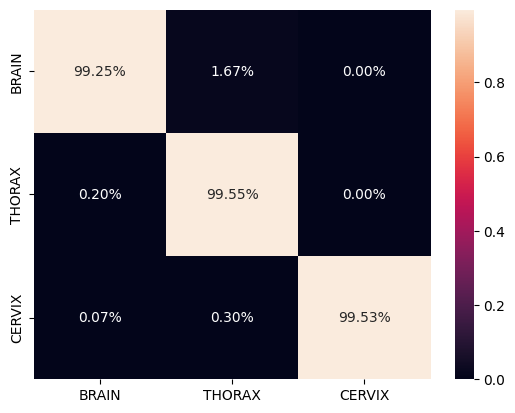

In [ ]:
#from neptunecontrib.monitoring.utils import pickle_and_send_artifact
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#Probabilità e predizione classe
y_pred = model.predict(brains)

pred_class = np.argmax(y_pred, axis=1)
gt = np.argmax(brains_label, axis=1)


#### Confusion Matrix
x_axis_labels = ["BRAIN",
                 "THORAX",
                 "CERVIX"]

conf = confusion_matrix(gt, pred_class)
cm = conf.astype('float') / conf.sum(axis=1)
k = sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=x_axis_labels,annot=True,
            fmt='.2%')

rep=classification_report(gt, pred_class, target_names=x_axis_labels)
#run["metrics/confusion_matrix"].upload(k)

# Log DataFrame con predizioni totali in Neptune.ai
df = pd.DataFrame(data={'y_test': gt, 'y_pred': pred_class, 'y_pred_probability': y_pred.max(axis=1)})
run['test/predictions'] = neptune.types.File.as_html(df)

In [ ]:
print(classification_report(gt, pred_class, target_names=x_axis_labels, digits=3))
cf_matrix=(classification_report(gt, pred_class, target_names=x_axis_labels, digits=3))

              precision    recall  f1-score   support

       BRAIN      0.997     0.993     0.995      1472
      THORAX      0.981     0.995     0.988       660
      CERVIX      1.000     0.995     0.998       645

    accuracy                          0.994      2777
   macro avg      0.993     0.994     0.994      2777
weighted avg      0.994     0.994     0.994      2777



In [ ]:
run["Metrics_ML_Classification/report"] = cf_matrix

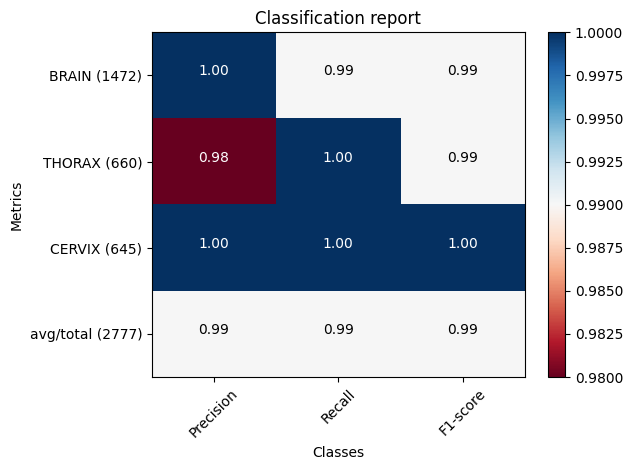

In [ ]:
import itertools
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()


def main():

    sampleClassificationReport = """             precision    recall  f1-score   support

       BRAIN       1.00      0.99      0.99      1472
      THORAX       0.98      1.00      0.99       660
      CERVIX       1.00      1.00      1.00       645

        avg / total       0.99      0.99      0.99      2777"""

    kk=plot_classification_report(sampleClassificationReport)
    plt.show()
    plt.close()


if __name__ == '__main__':
    main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(y_test, y_pred):

  n_classes = len(np.unique(y_test))
  y_test = label_binarize(y_test, classes=np.arange(n_classes))
  y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=(4,2))
  plt.figure(dpi=600)
  lw = 2
  plt.plot(fpr["micro"], tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink", linestyle=":", linewidth=4,)

  plt.plot(fpr["macro"], tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy", linestyle=":", linewidth=4,)

  colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver Operating Characteristic (ROC) curve")
  plt.legend()

TypeError: ignored

<Figure size 400x200 with 0 Axes>

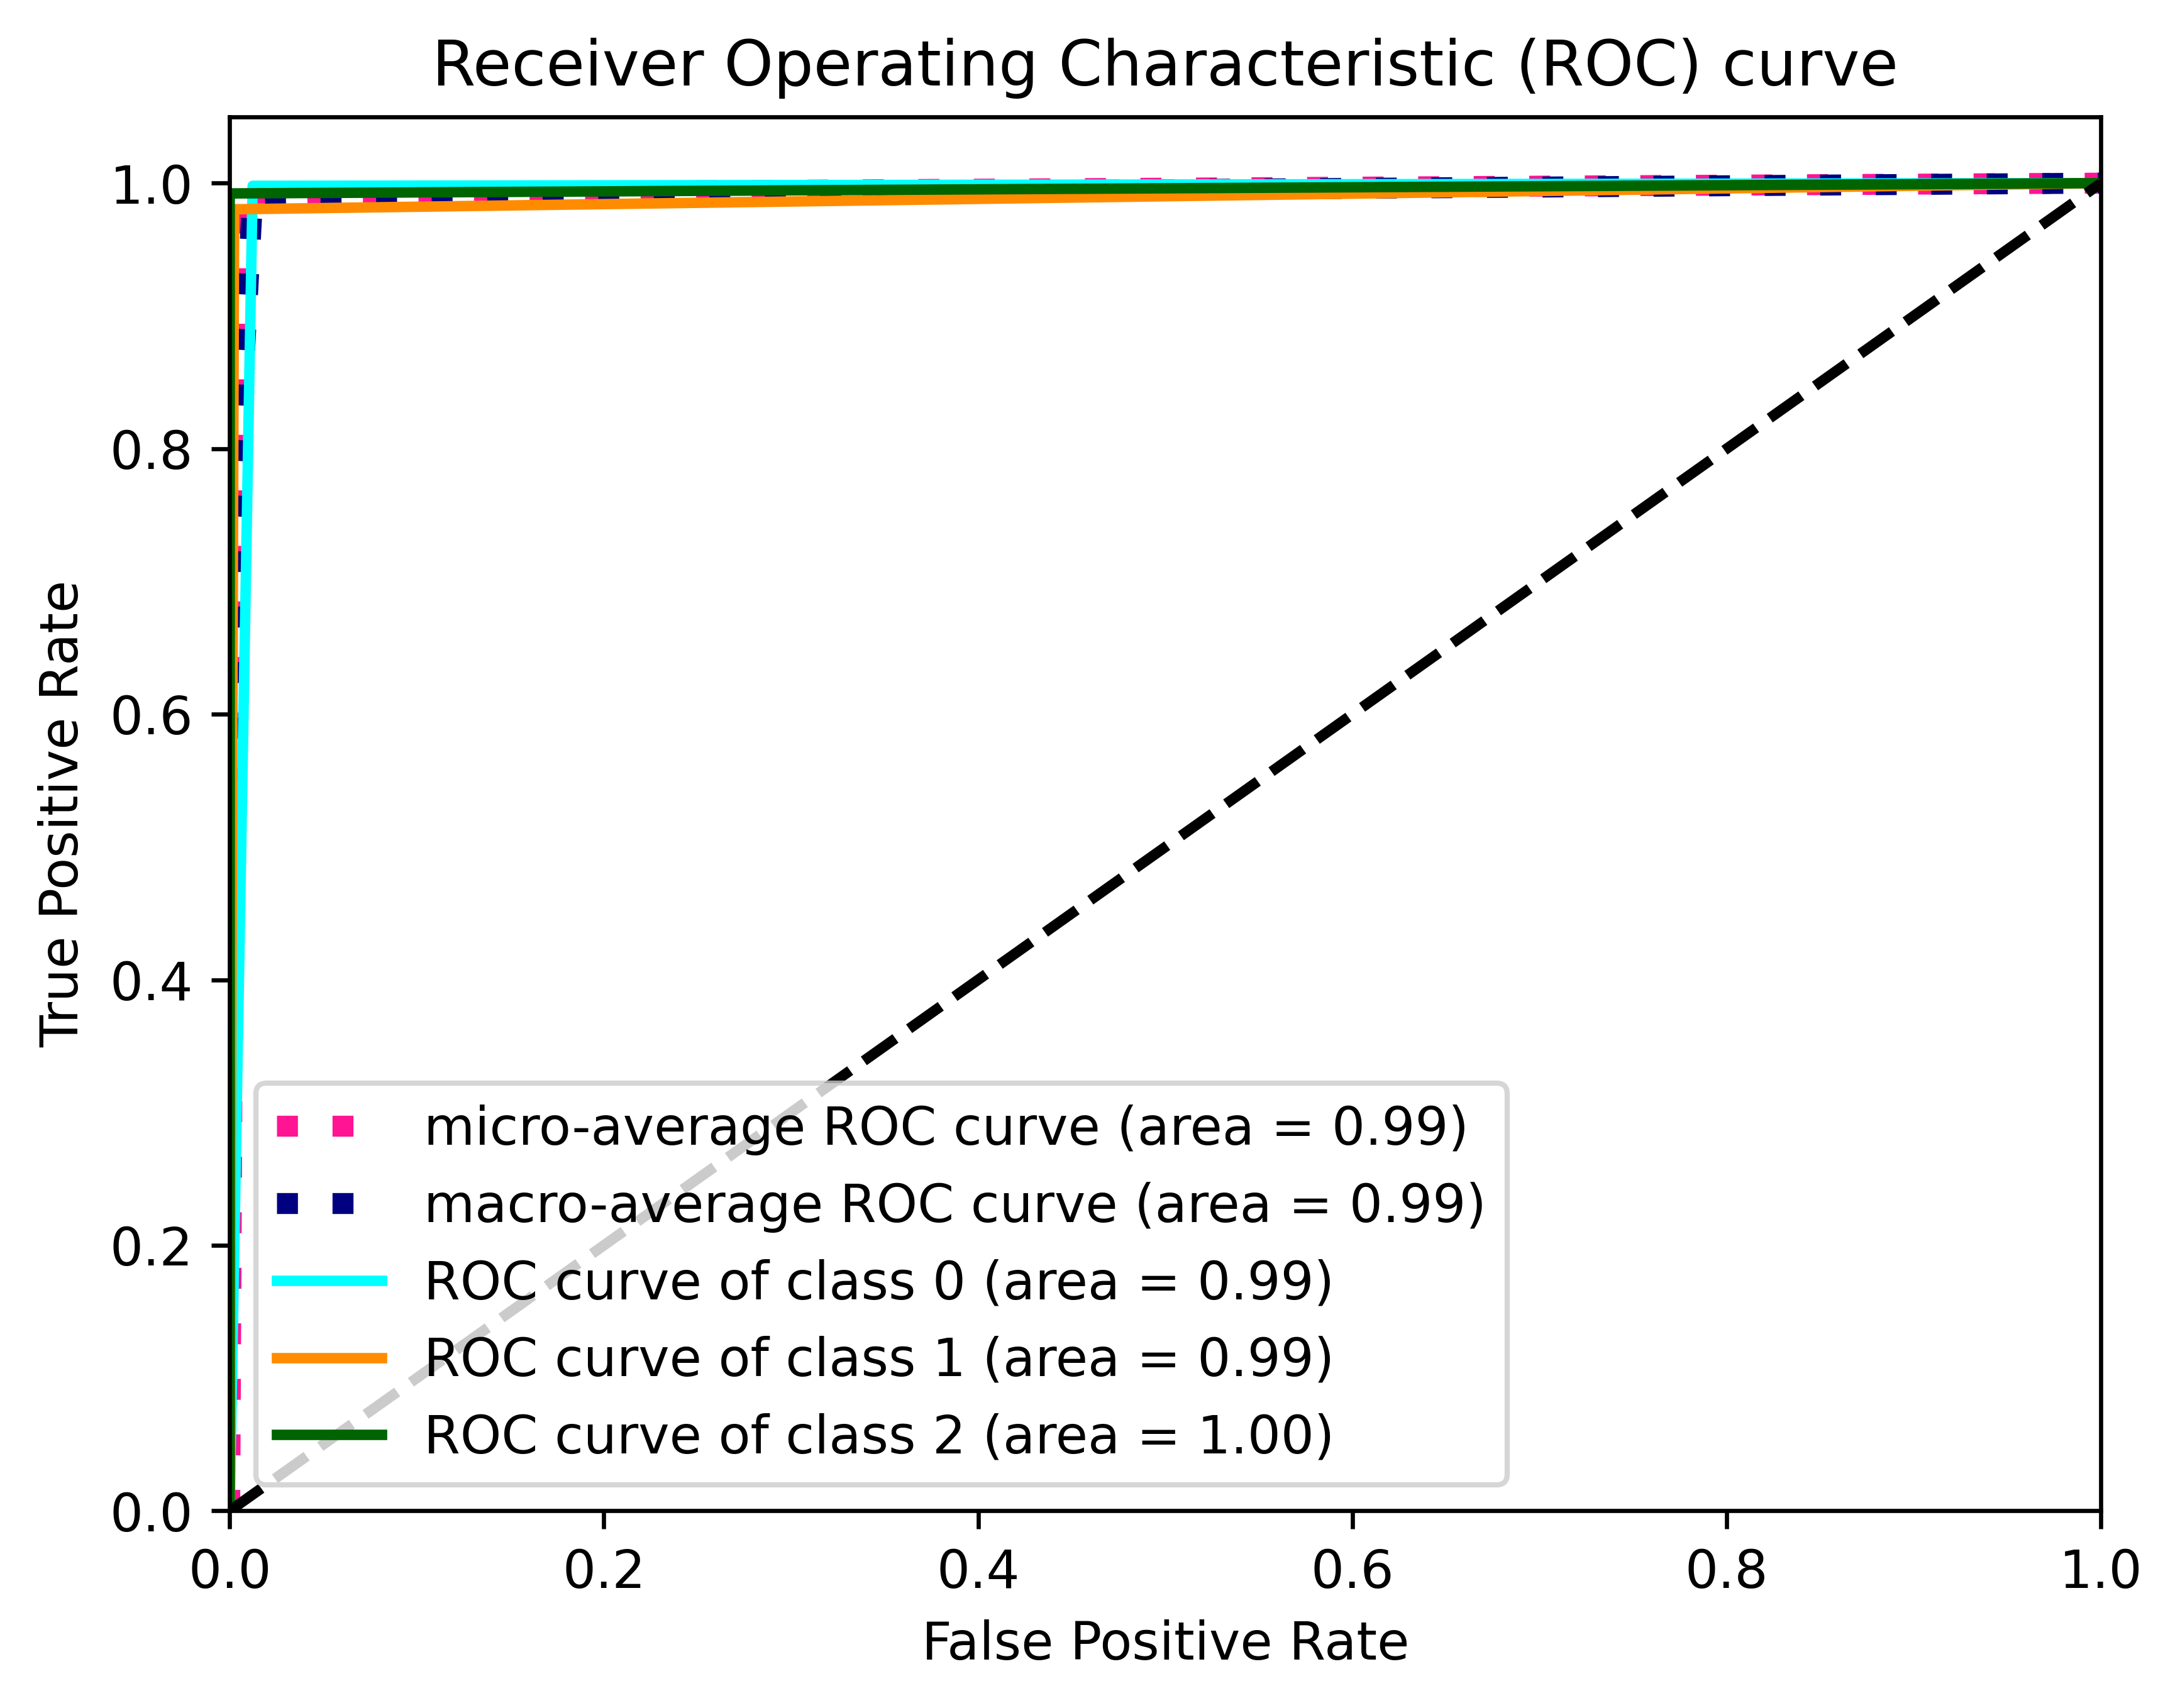

In [ ]:
k2=plot_roc_curve(gt, pred_class)
#run["metrics/roc-curve"].upload(k2)

**Explainability CAM** --> andrà poi al capitolo 9

In [ ]:
# funziona solo per reti neurali
cam_model = Model(inputs=model.input,
                    outputs=model.get_layer("conv2d_1").output)

cam_model.load_weights(weights_path, by_name=True)
uu = cam_model.predict(brains)

att = []
frames = []
for i in range(1980,1990):                           #brain 0-10 #cervix 2721,2748
    cam2 = uu[i,:,:,1]
    cam = cv2.resize(cam2,(224,224))
    a = (cam).astype(np.uint8)
    fig=plt.figure(i)
    #plt.title(y_pred[i])
    plt.imshow(brains[i][:,:,0],cmap='gray')
    plt.imshow(cam,cmap='jet', alpha=0.5)
    att.append(a)
    #run["CAM/fig-cam"].upload(fig)

In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/dli-mlops/Biomedical-Imaging/e/BIOM-43/metadata


## Carboon footprint reference

https://www.co2signal.com/  --> use to see the climate imapct for area

https://mlco2.github.io/impact/#compute --> carbon footprint AI model [prima di lanciare modello usiamo questo per una previsione di consumi]

https://codecarbon.io --> [dopo che è stato lanciato uso questo nella parte di monitoring delle emissioni]

- https://www.youtube.com/watch?v=xjDM7mY-3EA
- https://medium.com/@anuj_shah/computing-carbon-footprint-of-training-ai-models-7b0311ec056b --> example of footprint calc